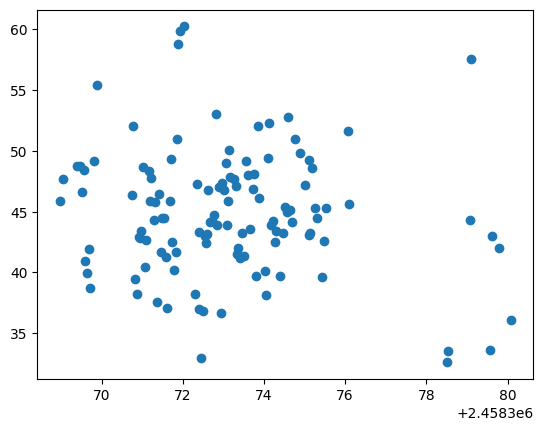

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astropy import wcs
from astropy.utils.data import download_file
from astropy.io import fits


interpedPos = pd.read_csv("./InterpolatedQuerryResultTESSdata_Sector2_Cam1_Ccd1_Cut1of16_wcs.csv")

name = " 2000 KR32 "

interpedNamePosIDs = interpedPos.index[interpedPos["Name"] == name]
interpedNamePos = interpedPos.loc[interpedNamePosIDs]


matchedNamePos = pd.read_csv(f"./{name}Matches.csv")

plt.scatter(matchedNamePos["Time"], matchedNamePos["flux"])

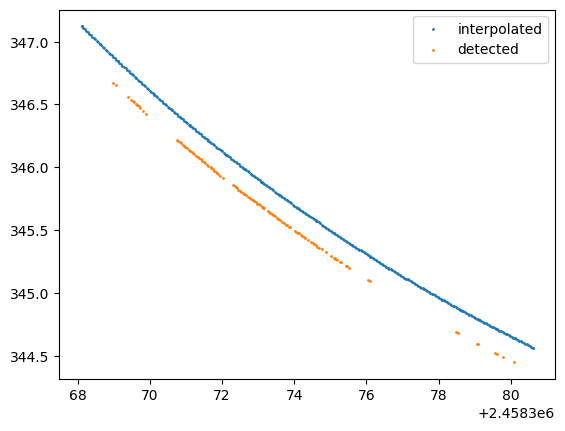

In [32]:
plt.scatter(interpedNamePos["epoch"],interpedNamePos["RA"], s=1, label="interpolated")
plt.scatter(matchedNamePos["Time"], matchedNamePos["RA"]-0.2, s=1, label="detected") # -0.2 ofset just to see better. interp is so good that its too hard to see
plt.legend()

In [68]:
allFluxes = np.load("./sector2_cam1_ccd1_cut1_of16_ReducedFlux.npy")
numFrames = allFluxes.shape[0]
allFluxes.shape

(1196, 512, 512)

In [80]:
targetWSC = fits.open("./TESSdata_Sector2_Cam1_Ccd1_Cut1of16_wcs.fits")[0]

w = wcs.WCS(targetWSC.header)

c=SkyCoord(interpedNamePos["RA"], interpedNamePos["Dec"], unit="deg")

interpedX, interpedY  = w.wcs_world2pix(c.ra,c.dec,0)

startTime = targetWSC.header["MJD-OBS"]
endTime = targetWSC.header["MJD-END"]

frameTimes = np.linspace(startTime,endTime,numFrames)

frameNums = [ np.argmin(np.abs(frameTimes-(time-2400000.5))) for time in interpedNamePos["epoch"] ] #2400000.5 is ofset between JD and MJD

interpedNamePos["epoch"].max() - interpedNamePos["epoch"].min()



xUnq, xUnqId = np.unique(interpedX, return_index=True)
yUnq, yUnqId = np.unique(interpedY, return_index=True)
fUnq, fUnqId = np.unique(frameNums, return_index=True)

xUnq = xUnq.round()


# assert np.array_equal()




array([181, 182, 182, 183, 184, 185, 186, 187, 187, 188, 189, 190, 191,
       191, 191, 192, 193, 194, 195, 196, 196, 197, 198, 199, 200, 200,
       200, 201, 202, 203, 204, 205, 205, 206, 207, 208, 209, 209, 210,
       210, 211, 212, 213, 214, 214, 215, 216, 217, 218, 219, 220, 220,
       220, 221, 222, 223, 224, 225, 226, 226, 227, 228, 229, 230, 231,
       231, 232, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 241,
       241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 252,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
       288, 289, 290, 291, 292, 293, 294, 295, 297, 298, 299, 300, 300,
       301, 302, 303, 304, 305, 306, 307, 308, 310, 311, 312, 313, 313,
       314, 315, 316, 317, 318, 320, 321, 322, 323, 324, 325, 326, 327,
       328, 329, 330, 331, 332, 333, 335, 336, 337, 338, 339, 34

In [81]:
theseFluxes = allFluxes[fUnq,xUnq[].round().astype(int),yUnq.round().astype(int)]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (312,) (324,) (324,) 